In [1]:
# Let us import some awesome libraries!
import pandas as pd
import numpy as np
import math
import os
from operator import itemgetter
import datetime

import pygal

# Definition of some constants.
DATASETS_LOCATION = 'drilled-informations/commits-information'

In [2]:
# Let us load the commits datasets.

projects_commits = {}

for filename in map(lambda filename: filename.split('.csv')[0], os.listdir(DATASETS_LOCATION)):
    commits = pd.read_csv(DATASETS_LOCATION + '/' + filename + '.csv')
    
    # Add a PROJECT column because they are going to be merged.
    commits['PROJECT'] = filename
    
    # The generated timestamps are 1000 times to big for unknown reason.
    commits['TIMESTAMP'] = commits['TIMESTAMP'].apply(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000))
    
    projects_commits[filename] = commits
    
projects_commits['scikit-learn'].sample(3)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT
23445,5146e88e0ce61837900cd405cca572084ae3b091,Balakumaran Manoharan,manoharan.balakumaran@gmail.com,22,2017-07-30 07:22:10,100,102,0,scikit-learn
7272,adfae9b22d7cc70bec439058c6f2174f369c7ecf,Olivier Grisel,olivier.grisel@ensta.org,1,2011-12-20 10:53:14,3,3,0,scikit-learn
13552,9c7f446656febc495bf2a7816b53625920a38c59,Justin Vincent,justinvf@gmail.com,2,2013-07-14 04:21:09,10,5,0,scikit-learn


## Projects sizes

In [13]:
projects_names = projects_commits.keys()

projects_sizes = pd.Series(index = projects_names, 
                           data = list(map(lambda name: len(projects_commits[name]), projects_names)))

projects_sizes.sort_values(inplace = True)

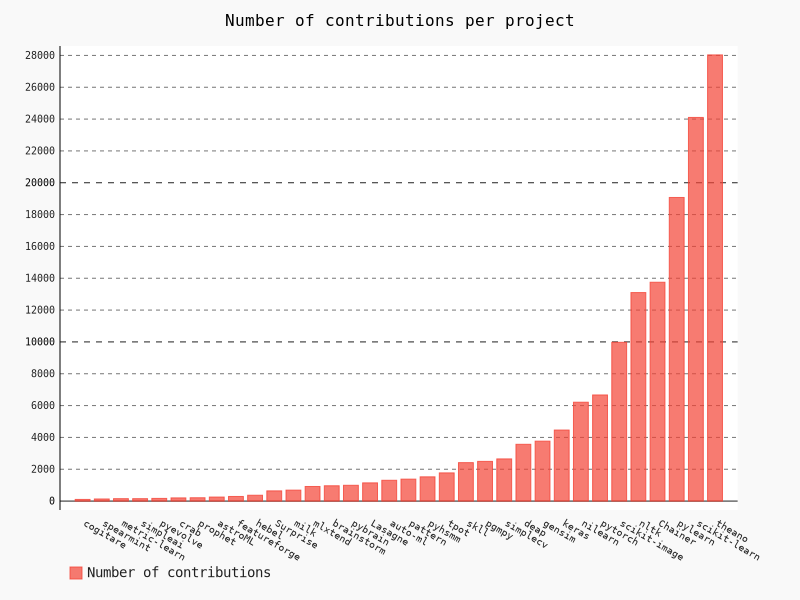

In [17]:
chart = pygal.Bar(legend_at_bottom = True, x_label_rotation = 30)

chart.title = 'Number of contributions per project'

chart.x_labels = projects_sizes.index
chart.add('Number of contributions', projects_sizes.values)

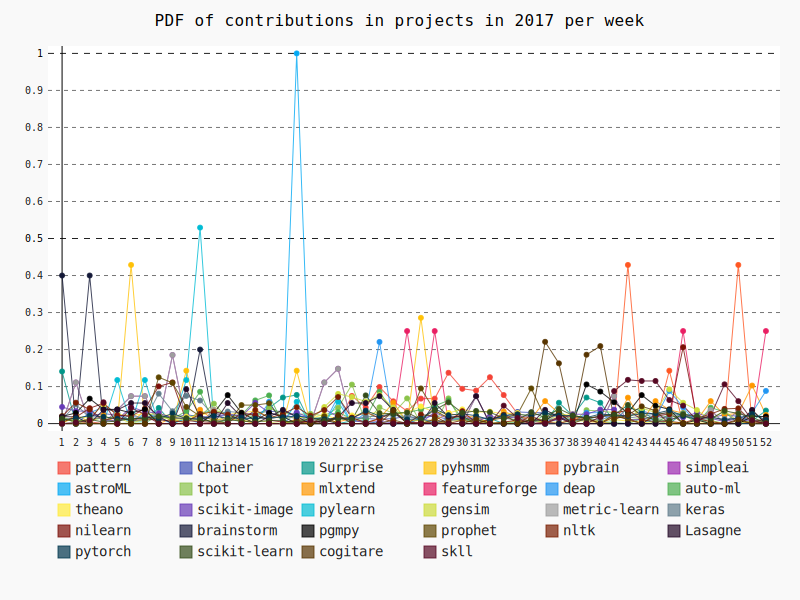

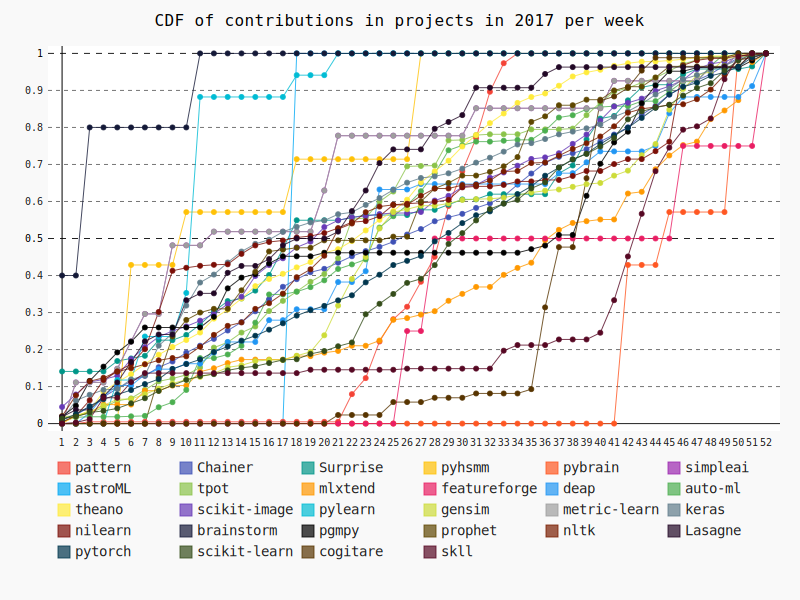

In [54]:
# Display the count of commits per week of 2017.
def normalized_contributions_per_week(project_commits):
    project_commits['WEEK_NUMBER'] = project_commits['TIMESTAMP'].apply(lambda date: date.isocalendar()[1])
    
    commits_2017 = project_commits[(project_commits['TIMESTAMP'] >= datetime.datetime(2017, 1, 1, 0, 0)) & (project_commits['TIMESTAMP'] < datetime.datetime(2018, 1, 1, 0, 0))]

    counts = commits_2017['WEEK_NUMBER'].value_counts().add(pd.Series(index = range(1, 53), data = 0), fill_value = 0).fillna(0)
 
    counts.sort_index(inplace = True)
    sum_commits = counts.sum()
    
    if sum_commits > 0:
        counts /= sum_commits
    
    return counts

def values_to_cdf(values):
    for i in range(1, len(values)):
        values[i] += values[i - 1]
        
    return values

pdf = pygal.Line(legend_at_bottom = True)
pdf.title = 'PDF of contributions in projects in 2017 per week'
pdf.x_labels = range(1, 53)

cdf = pygal.Line(legend_at_bottom = True)
cdf.title = 'CDF of contributions in projects in 2017 per week'
cdf.x_labels = range(1, 53)

for name in projects_commits.keys():#['nltk', 'Chainer', 'pylearn', 'scikit-learn', 'theano']:
    counts = normalized_contributions_per_week(projects_commits[name]).values
    
    if counts.sum() > 0:
        pdf.add(name, list(counts))
        cdf.add(name, values_to_cdf(counts))

display({'image/svg+xml': pdf.render()}, raw = True)
display({'image/svg+xml': cdf.render()}, raw = True)